In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-21 00:13:04.375837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 00:13:04.385385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760998384.398051  627316 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760998384.402194  627316 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 00:13:04.414560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

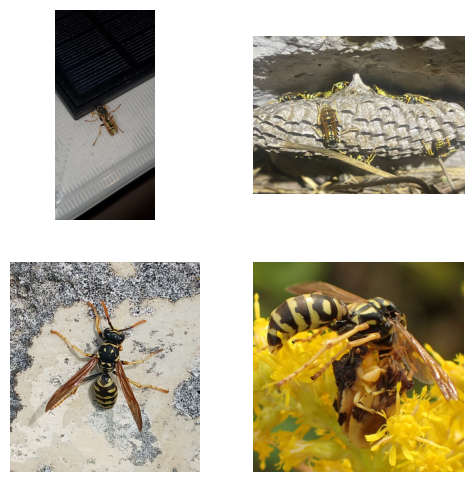

In [6]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [7]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [8]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [9]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [10]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
for layer in base_model.layers[:-3]:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_627316/2857167800.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1760998388.011968  627316 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 642 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1760998388.013000  627316 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45438 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [11]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [12]:
optimizer = Adam(learning_rate=0.0001) 

In [13]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [14]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [15]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1760998391.743307  628087 service.cc:148] XLA service 0x7efe9801cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760998391.743349  628087 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1760998391.743358  628087 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 00:13:11.807795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760998392.153344  628087 cuda_dnn.cc:529] Loaded cuDNN version 91200
2025-10-21 00:13:13.247186: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 406.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2

186/344 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.0252 - loss: 4.9123

E0000 00:00:1760998425.267918  628087 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760998425.391491  628087 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-21 00:13:46.065379: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 597.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1760998427.909494  628087 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760998428.039620  628087 gpu_timer.cc:82] Delay kernel timed out: measured t

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.0382 - loss: 4.7854

E0000 00:00:1760998466.791348  628088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760998466.916874  628088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760998469.402525  628088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760998469.528990  628088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_average_precision = 0.1426
344/344 ━━━━━━━━━━━━━━━━━━━━ 103s 275ms/step - accuracy: 0.0653 - loss: 4.5397 - val_accuracy: 0.1636 - val_loss: 3.9246 - val_average_precision: 0.1426 - learning_rate: 1.0000e-04
Epoch 2/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1824 - loss: 3.7161
Epoch 2: val_average_precision = 0.2540
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.2041 - loss: 3.5516 - val_accuracy: 0.2700 - val_loss: 3.1446 - val_average_precision: 0.2540 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3040 - loss: 2.9532
Epoch 3: val_average_precision = 0.3174
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.3103 - loss: 2.8678 - val_accuracy: 0.3327 - val_loss: 2.7557 - val_average_precision: 0.3174 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3831 - loss: 2.4806
Epoch 4: val_average_precision = 0.3549
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 229ms/step - accuracy: 0.3888 - loss: 2.4515 - val_accuracy: 0.3789 - val_loss: 2.5681 - val_average_precision: 0.3549 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4546 - loss: 2.1628
Epoch 5: val_average_precision = 0.3767
344/344 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.4564 - loss: 2.1326 - val_accuracy: 0.3830 - val_loss: 2.4681 - val_average_precision: 0.3767 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5109 - loss: 1.8825
Epoch 6: val_average_precision = 0.3853
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.5071 - loss: 1.8905 - val_accuracy: 0.3896 - val_loss: 2.4091 - val_average_precision: 0.3853 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5591 - loss: 1.6651
Epoch 7: val_average_precision = 0.3956
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.5542 - loss: 1.6701 - val_accuracy: 0.4043 - val_loss: 2.3649 - val_average_precision: 0.3956 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6112 - loss: 1.4705
Epoch 8: val_average_precision = 0.4023
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.5985 - loss: 1.4974 - val_accuracy: 0.4087 - val_loss: 2.3398 - val_average_precision: 0.4023 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6378 - loss: 1.3162
Epoch 9: val_average_precision = 0.4048
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.6356 - loss: 1.3350 - val_accuracy: 0.4076 - val_loss: 2.3943 - val_average_precision: 0.4048 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6776 - loss: 1.1790
Epoch 10: val_average_precision = 0.4143
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 229ms/step - accuracy: 0.6719 - loss: 1.2031 - val_accuracy: 0.4193 - val_loss: 2.3270 - val_average_precision: 0.4143 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7211 - loss: 1.0282
Epoch 11: val_average_precision = 0.4174
344/344 ━━━━━━━━━━━━━━━━━━━━ 77s 225ms/step - accuracy: 0.7081 - loss: 1.0646 - val_accuracy: 0.4112 - val_loss: 2.3529 - val_average_precision: 0.4174 - learning_rate: 1.0000e-04
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7566 - loss: 0.9068
Epoch 12: val_average_precision = 0.4141
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.7477 - loss: 0.9308 - val_accuracy: 0.4156 - val_loss: 2.3967 - val_average_precision: 0.4141 - learning_rate: 1.0000e-04
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7887 - loss: 0.7887
Epoch 13: val_average_precision = 0.4157
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.7737 - loss: 0.8252 - val_accuracy: 0.4120 - val_loss: 2.4043 - val_average_precision: 0.4157 - learning_rate: 1.0000e-04
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8160 - loss: 0.6812
Epoch 14: val_average_precision = 0.4192

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.8013 - loss: 0.7195 - val_accuracy: 0.4164 - val_loss: 2.4565 - val_average_precision: 0.4192 - learning_rate: 1.0000e-04
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8505 - loss: 0.5932
Epoch 15: val_average_precision = 0.4229
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.8469 - loss: 0.5979 - val_accuracy: 0.4332 - val_loss: 2.3697 - val_average_precision: 0.4229 - learning_rate: 5.0000e-05
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8672 - loss: 0.5373
Epoch 16: val_average_precision = 0.4217
344/344 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.8600 - loss: 0.5484 - val_accuracy: 0.4288 - val_loss: 2.4084 - val_average_precision: 0.4217 - learning_rate: 5.0000e-05
Epoch 17/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8800 - loss: 0.4837
Epoch 17: val_average_precision = 0.4219
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.8701 - loss: 0.5004 - val_accuracy: 0.4325 - val_loss: 2.4410 - val_average_precision: 0.4219 - learning_rate: 5.0000e-05
Epoch 18/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8835 - loss: 0.4606
Epoch 18: val_average_precision = 0.4239
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 231ms/step - accuracy: 0.8777 - loss: 0.4799 - val_accuracy: 0.4299 - val_loss: 2.4269 - val_average_precision: 0.4239 - learning_rate: 5.0000e-05
Epoch 19/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8912 - loss: 0.4246
Epoch 19: val_average_precision = 0.4196

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.8863 - loss: 0.4400 - val_accuracy: 0.4237 - val_loss: 2.4484 - val_average_precision: 0.4196 - learning_rate: 5.0000e-05
Epoch 20/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9024 - loss: 0.3956
Epoch 20: val_average_precision = 0.4243
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.9049 - loss: 0.3898 - val_accuracy: 0.4329 - val_loss: 2.4485 - val_average_precision: 0.4243 - learning_rate: 2.5000e-05
Epoch 21/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9132 - loss: 0.3660
Epoch 21: val_average_precision = 0.4238
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.9115 - loss: 0.3716 - val_accuracy: 0.4318 - val_loss: 2.4467 - val_average_precision: 0.4238 - learning_rate: 2.5000e-05
Epoch 22/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9214 - loss: 0.3370
Epoch 22: val_average_precision = 0.4219
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.9190 - loss: 0.3471 - val_accuracy: 0.4318 - val_loss: 2.4436 - val_average_precision: 0.4219 - learning_rate: 2.5000e-05
Epoch 23/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9204 - loss: 0.3408
Epoch 23: val_average_precision = 0.4213

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.9153 - loss: 0.3527 - val_accuracy: 0.4318 - val_loss: 2.4637 - val_average_precision: 0.4213 - learning_rate: 2.5000e-05
Epoch 24/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9162 - loss: 0.3308
Epoch 24: val_average_precision = 0.4222
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.9205 - loss: 0.3271 - val_accuracy: 0.4321 - val_loss: 2.4670 - val_average_precision: 0.4222 - learning_rate: 1.2500e-05
Epoch 25/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9248 - loss: 0.3189
Epoch 25: val_average_precision = 0.4225
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.9245 - loss: 0.3195 - val_accuracy: 0.4321 - val_loss: 2.4655 - val_average_precision: 0.4225 - learning_rate: 1.2500e-05
Epoch 26/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9320 - loss: 0.2981
Epoch 26: val_average_precision = 0.4217
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.9318 - loss: 0.3023 - val_accuracy: 0.4325 - val_loss: 2.4711 - val_average_precision: 0.4217 - learning_rate: 1.2500e-05
Epoch 27/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9318 - loss: 0.2966
Epoch 27: val_average_precision = 0.4229

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
344/344 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.9321 - loss: 0.2984 - val_accuracy: 0.4270 - val_loss: 2.4816 - val_average_precision: 0.4229 - learning_rate: 1.2500e-05
Epoch 28/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


310/344 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9379 - loss: 0.2837

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
model.save('../models/model_127_species_exp2.h5')